## Training UNET with RGB images

Let's start by importing the required libraries and defining the paths of our training and test data.
The scope of this notebook is limited to:

1. Reading training images from image_path and mask_path
2. Setting up a data generator (imports from 'data.py' )
3. Training a simple UNET
4. Testing an image stored in test_path. The ground truth for the test image is also stored in test path as 'GT_mask.png'.

In [1]:
import os,numpy,pandas
from glob import glob 
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Reshape, Activation, UpSampling2D
from tensorflow.keras.optimizers import Adam
from skimage.io import imread 
%matplotlib inline  

#path vars
data_dir=r'Image_and_annotations'
image_path=r'data\membrane\train\image'    
mask_path=r'data\membrane\train\label'
test_path=r'data\membrane\test'
num_class=4
#Certain regions in the ground truth mask are unlabelled. Let's add an extra class for training:
label={'unlabelled':0,'background':1,'wound':2,'skin':3}

C:\Users\rahul\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\rahul\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\rahul\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)]

In [2]:
#The Unet we are going to use
"""
UNET model file for multi class segmentation
"""
def downsampler(input_layer, filters=32,kernel=3):
    conv0 = Conv2D(filters, kernel, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_layer)
    conv = Conv2D(filters, kernel, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0)
    return conv, MaxPooling2D(pool_size=(2,2))(conv)

def upsampler(input_layer,skips,filters=32, kernel=3):
    up0 = Conv2D(filters, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(input_layer))
    merge = concatenate([skips,up0],axis=3)
    conv = Conv2D(filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)
    conv = Conv2D(filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    return conv

def unet(input_size = (256,256,3)):
    inputs = Input(input_size)
    #downward layers
    conv1, pool1= downsampler(inputs,64)
    conv2, pool2= downsampler(pool1,128)
    conv3, pool3= downsampler(pool2,256)
    conv4, pool4= downsampler(pool3,512)
    conv5,_= downsampler(pool4,1024)
    drop2= Dropout(0.5)(conv5)
    #upward layers
    conv6= upsampler(drop2,conv4,512)
    conv7= upsampler(conv6,conv3,256)
    conv8= upsampler(conv7,conv2,128)
    conv9= upsampler(conv8,conv1,64)   
    
    conv9 = Conv2D(num_class, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    
    reshape = Reshape((256 * 256,num_class), input_shape = (256, 256,num_class))(conv9)
    
    activation = Activation('softmax')(reshape)
    model = Model(inputs, activation)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    model.summary()
    return model



In [6]:
#data generator
from data import trainGenerator,testGenerator
batch_size=4
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

tgen = trainGenerator(batch_size,'data/membrane/train','image','label',data_gen_args,num_class = num_class,
                        flag_multi_class = True,image_color_mode = "rgb",mask_color_mode="rgb")


In [7]:
#Generate a sample batch and display first  with its label
train_imgs,mask=next(tgen)
train_mask=numpy.reshape(mask,(batch_size-1,256,256,num_class))
train_mask=numpy.argmax(train_mask,axis=-1)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(train_imgs[0],vmin=train_imgs[0].min(),vmax=train_imgs[0].max())
ax[1].imshow(train_mask[0],vmin=train_mask[0].min(),vmax=train_mask[0].max())

Found 15 images belonging to 1 classes.
Found 15 images belonging to 1 classes.


ValueError: cannot reshape array of size 1048576 into shape (3,256,256,4)

In [9]:
#Main
model = unet()
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1,save_best_only=True)
model.fit_generator(tgen,steps_per_epoch=100,epochs=10,callbacks=[model_checkpoint])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_46[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_47[0][0]                  
____________________________________________________________________________________________

Epoch 1/10
 99/100 [============================>.] - ETA: 0s - loss: 0.9202 - acc: 0.5983
Epoch 00001: loss improved from inf to 0.92290, saving model to unet_membrane.hdf5
100/100 [==============================] - 36s 358ms/step - loss: 0.9214 - acc: 0.5983
Epoch 2/10
 99/100 [============================>.] - ETA: 0s - loss: 0.7061 - acc: 0.6740
Epoch 00002: loss improved from 0.92290 to 0.70752, saving model to unet_membrane.hdf5
100/100 [==============================] - 30s 303ms/step - loss: 0.7043 - acc: 0.6752
Epoch 3/10
 99/100 [============================>.] - ETA: 0s - loss: 0.4467 - acc: 0.8224
Epoch 00003: loss improved from 0.70752 to 0.44403, saving model to unet_membrane.hdf5
100/100 [==============================] - 31s 307ms/step - loss: 0.4457 - acc: 0.8229
Epoch 4/10
 99/100 [============================>.] - ETA: 0s - loss: 0.3667 - acc: 0.8483
Epoch 00004: loss improved from 0.44403 to 0.36457, saving model to unet_membrane.hdf5
100/100 [======================

1/1 [==============================] - 0s 405ms/step
[0 1 2 3]


Text(0.5, 1.0, 'Predicted Mask')

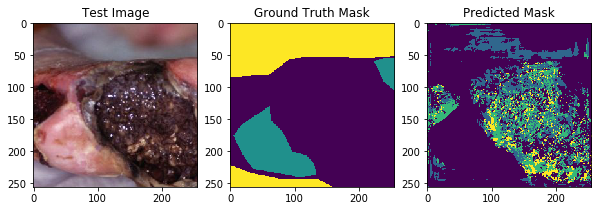

In [59]:
#Test generator
testGene = testGenerator(test_path,num_image=1,flag_multi_class = True,as_gray = False)
results = model.predict_generator(testGene,1,verbose=1)
r=numpy.reshape(results[0,:,:],(256,256,num_class))
r=numpy.argmax(r,axis=-1)
print(numpy.unique(r))   
#%%Visulaize results
testIm=imread(test_path+'/0.png')
testGT=imread('data/membrane/test/Gt_mask.png')#make sure the mask was created(~line 80)
testGT=numpy.argmax(testGT,axis=-1)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(testIm,vmin=testIm.min(),vmax=testIm.max())
ax[0].set_title('Test Image')
ax[1].imshow(testGT,vmin=testGT.min(),vmax=testGT.max())
ax[1].set_title('Ground Truth Mask')
ax[2].imshow(r,vmin=r.min(),vmax=r.max())
ax[2].set_title('Predicted Mask')


In [58]:
testGT.shape

(256, 256, 3)

(256, 256)